# Projeto ADC

## Import libraries

In [6]:
from datetime import datetime
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

## Converter txt para parquet

In [7]:
product_id = []
user_id = []
rev_score = []
rev_time = []

with open("movies_light.txt", "r") as file:
    
    while True:
        product_line = file.readline().strip()
        if not product_line:
            break
        user_line = file.readline().strip()
        file.readline()  # Skip 3rd line
        file.readline()  # Skip 4th line
        score_line = file.readline().strip()
        time_line = file.readline().strip()
        file.readline()  # Skip 7th line
        file.readline()  # Skip 8th line
        file.readline()  # Skip 9th line

        product_id.append(product_line.split(":")[1].strip())
        user_id.append(user_line.split(":")[1].strip())
        rev_score.append(float(score_line.split(":")[1].strip()))
        rev_time.append(int(time_line.split(":")[1].strip()))
        

# make dataframe
df = pd.DataFrame(
    {
        "prod_id": product_id,
        "user_id": user_id,
        "rev_score": rev_score,
        "rev_time": rev_time
    }
)

# make parquet file
df.to_parquet("movies_light.parquet")

Dataset exploration

In [2]:
# Define the time frame for the entire dataset
print("Building...")
start_month = datetime(1997, 8, 1) # August 1997
end_month = datetime(2012, 10, 31) # October 2012

# Convert the datetime objects to UNIX timestamps
start_timestamp = int(start_month.timestamp())
end_timestamp = int(end_month.timestamp())

# Create a new graph for the filtered data
G = nx.Graph()

# Open and process the file
with open('movies.txt', 'r', encoding='utf-8', errors='ignore') as f:
    user_id, product_id, review_time = None, None, None  # Reset variables

    for line in f:
        # Extract the relevant fields
        if line.startswith("review/userId:"):
            user_id = line[len("review/userId:"):].strip()
        elif line.startswith("product/productId:"):
            product_id = line[len("product/productId:"):].strip()
        elif line.startswith("review/time:"):
            review_time = int(line[len("review/time:"):].strip())
        
        # If all attributes for a review are ready, process it
        if user_id and product_id and review_time is not None:
            # Check if the review time falls within the dataset's timespan
            if start_timestamp <= review_time <= end_timestamp:
                # Convert review time to a month-year string (e.g., "1997-08")
                review_month = datetime.fromtimestamp(review_time).strftime("%Y-%m")
                
                # Add nodes with attributes
                G.add_node(user_id, type='user')
                G.add_node(product_id, type='product')
                
                # Add edge to the graph with the month attribute
                G.add_edge(user_id, product_id, time=review_time, month=review_month)
            
            # Reset variables for the next review
            user_id, product_id, review_time = None, None, None

# Count total users and products
users = 0
products = 0
for _, attr in G.nodes(data=True):
    node_type = attr.get('type')
    if node_type == 'user':
        users += 1
    elif node_type == 'product':
        products += 1

# Output the number of edges to check the graph
print(f"Total number of users: {users}") # 889176 users
print(f"Total number of products: {products}") # 253059 products
print(f"Total number of edges (reviews): {G.number_of_edges()}") # 7831442 edges (reviews)

Building...
Total number of users: 889176
Total number of products: 253059
Total number of edges (reviews): 7831442


In [ ]:
target_year = "1999" # 1997: 126 nodes; 1998: 5029 nodes; 1999: 

# Create a subgraph for the year
print(f"Making edges...")
year_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d.get('month').startswith(target_year)]
G_year = nx.Graph()

print(f"Adding edges...")
G_year.add_edges_from(year_edges)

print("Copying node attributes...")
for node in G_year.nodes:
    if node in G:
        G_year.nodes[node].update(G.nodes[node])

print("Calculating numbers...")
node_types = nx.get_node_attributes(G, "type")
filtered_users = set()
filtered_products = set()
for n in G_year.nodes:
    if node_types.get(n) == "user":
        filtered_users.add(n)
    elif node_types.get(n) == "product":
        filtered_products.add(n)
        
print(f"For {target_year}, there are {len(filtered_users)} users, {len(filtered_products)} products and {G_year.number_of_edges()} edges (reviews).")

Making edges...


In [ ]:
# Plot the graph
print("Plotting graph...")
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_year)

# Draw user nodes
print("Drawing user nodes...")
nx.draw_networkx_nodes(G_year, pos, nodelist=filtered_users, node_size=50, node_color="blue", label="Users")

# Draw product nodes
print("Drawing product nodes...")
nx.draw_networkx_nodes(G_year, pos, nodelist=filtered_products, node_size=50, node_color="red", label="Products")

# Draw edges
print("Drawing edges...")
nx.draw_networkx_edges(G_year, pos, alpha=0.5, edge_color="gray")

# Add a legend and title
plt.title(f"Users vs. Products for {target_year} ({G_year.number_of_nodes()} nodes)")
plt.legend()
plt.axis("off")  # Turn off the axis

# save plot
print("Saving plot...")
output_filename = f"network_{target_year}.png"  # Change this as needed
plt.savefig(output_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {output_filename}")

print("Showing plot")
plt.show()

In [16]:
# Debugging: Look-up odd the user/product names and see if they're really that
print("Node types summary:")
for node, attr in G_year.nodes(data=True):
    print(f"Node: {node}, Type: {attr.get('type')}")
    product_edges = [(u, v) for u, v, attr in G_year.edges(data=True)
                 if G_year.nodes[u].get('type') == 'product' and G_year.nodes[v].get('type') == 'product']
print(f"Product-Product Edges: {product_edges}")
for u, v in product_edges:
    print(f"Edge between products: {u} (type: {G_year.nodes[u]['type']}), {v} (type: {G_year.nodes[v]['type']})")

Node types summary:
Node: A1EMDSTJDUE6B0, Type: user
Node: B003WTO5Y8, Type: product
Node: B002CMV1N4, Type: product
Node: B004VS4MSI, Type: product
Node: B00006NSCJ, Type: product
Node: B00005KIVV, Type: product
Node: B00005LINB, Type: product
Node: B00005KISI, Type: product
Node: B001BVAR6E, Type: product
Node: B00026L7OK, Type: product
Node: 6304524455, Type: product
Node: B00004S0V1, Type: product
Node: B00005MAYB, Type: product
Node: 6305073333, Type: product
Node: 0792842111, Type: product
Node: 6302171725, Type: product
Node: 6304213018, Type: product
Node: B003WTO5NE, Type: product
Node: 6305050058, Type: product
Node: B00004RLGC, Type: product
Node: B00006FN31, Type: product
Node: B00005LINC, Type: product
Node: AX9J0U8J6XTCY, Type: user
Node: B00004R6WT, Type: product
Node: B00004RWSD, Type: product
Node: B00005NGAL, Type: product
Node: B00004XMTJ, Type: product
Node: B0000A5BTN, Type: product
Node: B00004RX9F, Type: product
Node: B00004R774, Type: product
Node: 6305120706, T

Node: A2E7E9EWADK4S6, Type: user
Node: 6304819633, Type: product
Node: B0001HLT5M, Type: product
Node: 6301748115, Type: product
Node: 6303562515, Type: product
Node: B000HCWZYK, Type: product
Node: B0000D9PFA, Type: product
Node: 6305838208, Type: product
Node: B000VWIBXU, Type: product
Node: B00166RAY6, Type: product
Node: B003VBHA5I, Type: product
Node: 630423368X, Type: product
Node: B00024TD6G, Type: product
Node: B00019GHMK, Type: product
Node: B00008K7A9, Type: product
Node: 6304091338, Type: product
Node: A1268ZX3HDYDSH, Type: user
Node: 630409132X, Type: product
Node: 630581225X, Type: product
Node: 0792899342, Type: product
Node: 6302593123, Type: product
Node: B0028NGF2E, Type: product
Node: B00005UJYD, Type: product
Node: B005UYF7KY, Type: product
Node: A2RROM9KCYOYHJ, Type: user
Node: B00005LJBW, Type: product
Node: B004D5UW9W, Type: product
Node: B00004VY1X, Type: product
Node: B000059PPB, Type: product
Node: 157252510X, Type: product
Node: 6304689640, Type: product
Node:

Node: B000FFL2I4, Type: product
Node: B000I9UA30, Type: product
Node: 0800178394, Type: product
Node: 0767853954, Type: product
Node: B00006IW18, Type: product
Node: B001NJRWX0, Type: product
Node: 6303637639, Type: product
Node: B00008KDHM, Type: product
Node: B00008KDHN, Type: product
Node: B000VG66XS, Type: product
Node: B002MFV2KI, Type: product
Node: B000WQWPKA, Type: product
Node: B0000695JU, Type: product
Node: B000AZ2A4Y, Type: product
Node: B00009MEKJ, Type: product
Node: B00004RNN8, Type: product
Node: B000O76T86, Type: product
Node: B00023P4S8, Type: product
Node: B0000E6FPI, Type: product
Node: B00028491G, Type: product
Node: B000ERVK44, Type: product
Node: 6303431038, Type: product
Node: 630026906X, Type: product
Node: B00000IPH3, Type: product
Node: B0000A1M45, Type: product
Node: B007EJDGX8, Type: product
Node: B00005B1N2, Type: product
Node: 630507755X, Type: product
Node: 6305664838, Type: product
Node: B001K3BG3Q, Type: product
Node: B0001US8EO, Type: product
Node: B0

Node: B00004RYN9, Type: product
Node: B00004RW50, Type: product
Node: B00004D35Y, Type: product
Node: B000051NWR, Type: product
Node: B001Q9Z8LU, Type: product
Node: B001O7JHW0, Type: product
Node: 078062257X, Type: product
Node: B00004CXOH, Type: product
Node: A1X4JO8EJ1U5BR, Type: user
Node: B000BRM5GO, Type: product
Node: B00008WJDH, Type: product
Node: A2FZW6I4S86DLD, Type: user
Node: B005DWBLM6, Type: product
Node: B002QVOG1A, Type: product
Node: 6305131104, Type: product
Node: B002ZGW9DI, Type: product
Node: 6304633890, Type: product
Node: B00004TXII, Type: product
Node: B00008WJC0, Type: product
Node: A2YM6JTQIBZ8YC, Type: user
Node: 0800109481, Type: product
Node: B00164GD96, Type: product
Node: B00004TYY6, Type: product
Node: B001LT5TL4, Type: product
Node: B0019TVYNS, Type: product
Node: B00004T8WS, Type: product
Node: B00005Q799, Type: product
Node: B000C8Q9KK, Type: product
Node: B00004CJX0, Type: product
Node: B007USWCO2, Type: product
Node: 6303995713, Type: product
Node:

Node: B0000542CE, Type: product
Node: 6302718929, Type: product
Node: B001MKTYOK, Type: product
Node: B00335EQ3Q, Type: product
Node: A287U12WGQR73M, Type: user
Node: B00004XQU5, Type: product
Node: B00005V1Y0, Type: product
Node: 6302994063, Type: product
Node: B00004CYHM, Type: product
Node: B00005UQW2, Type: product
Node: B00005UQW1, Type: product
Node: B00006I04D, Type: product
Node: B00004D333, Type: product
Node: A3DADEPXDYUN6N, Type: user
Node: 6303575536, Type: product
Node: B00001XT6K, Type: product
Node: B00004R99W, Type: product
Node: 6304622465, Type: product
Node: 6301906764, Type: product
Node: 6301166698, Type: product
Node: B00004R99V, Type: product
Node: B003RACGZM, Type: product
Node: B00006LSH2, Type: product
Node: B00015G8MS, Type: product
Node: 630015467X, Type: product
Node: 6304978715, Type: product
Node: 6304978286, Type: product
Node: 6304481128, Type: product
Node: B00004CV6W, Type: product
Node: AW8HECSYCS27W, Type: user
Node: 6302804752, Type: product
Node: 

Node: 6302372488, Type: product
Node: 6304259115, Type: product
Node: B004VFK4WO, Type: product
Node: B004VFN4F8, Type: product
Node: B0000WN1OK, Type: product
Node: B00005T30I, Type: product
Node: A3ONIAZG2WA74H, Type: user
Node: 6302969603, Type: product
Node: B00004Y8E2, Type: product
Node: B008CJ0JR0, Type: product
Node: B008CJ0JS4, Type: product
Node: 0790737345, Type: product
Node: AXTYUQFRIR532, Type: user
Node: 0790737302, Type: product
Node: B001AQIYJC, Type: product
Node: B002GHHHKG, Type: product
Node: 0790739917, Type: product
Node: 0790739909, Type: product
Node: B00004RYL2, Type: product
Node: B001OKJXIK, Type: product
Node: B00004CY4G, Type: product
Node: B00004CXJF, Type: product
Node: B00004VYNL, Type: product
Node: 0790737310, Type: product
Node: B00004CQYW, Type: product
Node: AG4LKQ804ICNI, Type: user
Node: B005Q4CKI0, Type: product
Node: B006I0ZLFU, Type: product
Node: B004SIP86Q, Type: product
Node: 6303433766, Type: product
Node: B00006ADFL, Type: product
Node: B

Node: B001CAZL1A, Type: product
Node: B001CAZL1K, Type: product
Node: B000056H2C, Type: product
Node: B00005AXLH, Type: product
Node: A3MBYGJQUFB7Y5, Type: user
Node: AHV0OZ9UMWXKA, Type: user
Node: B007HJ9B5C, Type: product
Node: 0788805533, Type: product
Node: B006MOYGSA, Type: product
Node: B00004RX2X, Type: product
Node: B00004RYLS, Type: product
Node: B00004CYAK, Type: product
Node: B0001I55W4, Type: product
Node: B0001I55WE, Type: product
Node: B0001L3M6C, Type: product
Node: B00004CY6S, Type: product
Node: B00005CEWY, Type: product
Node: B006MOYFU4, Type: product
Node: B006MOYGNK, Type: product
Node: ALU2IJ2DZD86X, Type: user
Node: ALCC0HNCSF1DC, Type: user
Node: 6302462835, Type: product
Node: AAFVSO9LCAIAL, Type: user
Node: B004CIIXEQ, Type: product
Node: B004CIIXG4, Type: product
Node: 6301976126, Type: product
Node: B00004CNR1, Type: product
Node: B00004TYTI, Type: product
Node: B00005AUKD, Type: product
Node: A103JLCHO0993V, Type: user
Node: B00004RLFR, Type: product
Node: 

Node: B0007PALZ2, Type: product
Node: 078322172X, Type: product
Node: B00004VY5T, Type: product
Node: 078322608X, Type: product
Node: B0026FCNK2, Type: product
Node: B000I8COCQ, Type: product
Node: B000ICXQF6, Type: product
Node: 0783230702, Type: product
Node: 6304080921, Type: product
Node: B00004R73M, Type: product
Node: B00004R78L, Type: product
Node: B00004CIQG, Type: product
Node: A1VDAM337QETL1, Type: user
Node: 0800141709, Type: product
Node: 6302799066, Type: product
Node: B00000IQBI, Type: product
Node: B001DJLCPE, Type: product
Node: B00000J2L8, Type: product
Node: B000ZHCQ5U, Type: product
Node: B00004RLGO, Type: product
Node: B00008G4R9, Type: product
Node: B000P407K4, Type: product
Node: B0002XNSY0, Type: product
Node: 0800138015, Type: product
Node: B00004CZG7, Type: product
Node: B000055Y0X, Type: product
Node: 6301977963, Type: product
Node: A2T7K1TMKSKW84, Type: user
Node: B000I0Q2IQ, Type: product
Node: B000I5T3NW, Type: product
Node: B00004T0XP, Type: product
Node: 

Node: B0000844IZ, Type: product
Node: A2N0UXKBAJ0KQR, Type: user
Node: A7JKA3E43NS8D, Type: user
Node: B0019BMOLW, Type: product
Node: 6300218414, Type: product
Node: B000009OV2, Type: product
Node: A2LE0QD0MPTT1Q, Type: user
Node: 6302896444, Type: product
Node: 6302653061, Type: product
Node: AUQNQZ6SDLGZG, Type: user
Node: B000069I0H, Type: product
Node: A37AFJ5AFIT462, Type: user
Node: B00005LE3S, Type: product
Node: B00005YG8U, Type: product
Node: 630525625X, Type: product
Node: B004GF2T3Q, Type: product
Node: 0780619455, Type: product
Node: B004GF2TQ8, Type: product
Node: B000M2E322, Type: product
Node: A341TONY222YUN, Type: user
Node: 6300248437, Type: product
Node: B00004CJZL, Type: product
Node: B00004WGBD, Type: product
Node: AFBXWCXNA4P99, Type: user
Node: 6305074429, Type: product
Node: B000UL45C8, Type: product
Node: A3RY41UKLUX3X8, Type: user
Node: B00004CWBK, Type: product
Node: 6305142629, Type: product
Node: B00005221O, Type: product
Node: B00000ID1X, Type: product
Nod

Node: B001BM1USC, Type: product
Node: B0028O9WUA, Type: product
Node: B00006BT6D, Type: product
Node: B00004CQ9G, Type: product
Node: A2UZ8MTZY1PLLE, Type: user
Node: B000T6Z6BI, Type: product
Node: B00005U8F3, Type: product
Node: 6303454550, Type: product
Node: B00006FDAW, Type: product
Node: A2RVR2R37H0GC5, Type: user
Node: B001715H0O, Type: product
Node: B006TTC5A4, Type: product
Node: B008QW5G76, Type: product
Node: B00005JH9C, Type: product
Node: B000N6QOY2, Type: product
Node: B0006H32DY, Type: product
Node: 6300185206, Type: product
Node: 6301968824, Type: product
Node: B001712130, Type: product
Node: 6301232291, Type: product
Node: B002Q325KM, Type: product
Node: B000HT3Q2S, Type: product
Node: B000N6OLAG, Type: product
Node: 6301662946, Type: product
Node: A3BT6QLHSEX3RR, Type: user
Node: B0025X0SU2, Type: product
Node: B00004CIBZ, Type: product
Node: B00008AOTG, Type: product
Node: B00008AOTN, Type: product
Node: B002BVYGKG, Type: product
Node: A2UGOW062V7528, Type: user
Node

Node: B00004VXS5, Type: product
Node: A1PNFD2AXGLTHX, Type: user
Node: 6303050239, Type: product
Node: B00004TLJU, Type: product
Node: 6302786770, Type: product
Node: B00004STCB, Type: product
Node: B00004CYFT, Type: product
Node: B0011XBLV2, Type: product
Node: B00004CJ59, Type: product
Node: B004TJ1H2I, Type: product
Node: B00004RSW9, Type: product
Node: 0792842499, Type: product
Node: B003ZD9DO8, Type: product
Node: 0792836510, Type: product
Node: B0011XBLUS, Type: product
Node: B000MRK7AO, Type: product
Node: B00004RCL6, Type: product
Node: B00004TLDQ, Type: product
Node: B0001EYT2A, Type: product
Node: 0792836502, Type: product
Node: B0001GF2DS, Type: product
Node: 6301971272, Type: product
Node: A281TPZ4FEN7C9, Type: user
Node: B00004CRCO, Type: product
Node: B008GBBGOO, Type: product
Node: B008COX792, Type: product
Node: 6304766785, Type: product
Node: B007WZTMCI, Type: product
Node: B000063VCK, Type: product
Node: B00008L3SP, Type: product
Node: A2KCCW2O2OMURK, Type: user
Node:

Node: 079074015X, Type: product
Node: 0790731916, Type: product
Node: B00004ROZF, Type: product
Node: B00004D2VZ, Type: product
Node: A1CM5BV7NNL0F, Type: user
Node: B0060D2Q9Y, Type: product
Node: B003SHYT5O, Type: product
Node: B000065V3P, Type: product
Node: 6302676711, Type: product
Node: B0001IMC9S, Type: product
Node: 6303058957, Type: product
Node: ARRCLK1IDMK9J, Type: user
Node: B001P5QC1U, Type: product
Node: B000A9QKLE, Type: product
Node: B0000399WH, Type: product
Node: B0008KLW2W, Type: product
Node: 630305899X, Type: product
Node: B00004CP7U, Type: product
Node: B001P5S6FU, Type: product
Node: B00004ROUR, Type: product
Node: B00004R6MT, Type: product
Node: A1QWAKXBL9OYM1, Type: user
Node: 6303916945, Type: product
Node: B00004VY1D, Type: product
Node: B001FHFK48, Type: product
Node: B000ICZD5C, Type: product
Node: B000056IEI, Type: product
Node: 6304346166, Type: product
Node: 6302937175, Type: product
Node: 0783226985, Type: product
Node: 6304726953, Type: product
Node: 6

Node: 6304155697, Type: product
Node: AB2C5F8K0CRHC, Type: user
Node: 6300214680, Type: product
Node: B001IXXYBU, Type: product
Node: B0000507P9, Type: product
Node: B001K36GIQ, Type: product
Node: B002A9POR8, Type: product
Node: B00004CIHM, Type: product
Node: B00005UPOA, Type: product
Node: 6303356761, Type: product
Node: A1KIZMVC6OGS6K, Type: user
Node: B00004RYAH, Type: product
Node: B002GCOPJ2, Type: product
Node: B00004RQKN, Type: product
Node: B004MPOX0M, Type: product
Node: B00009KOXV, Type: product
Node: 6305428484, Type: product
Node: 6305178143, Type: product
Node: AJ2G9WOWNA31F, Type: user
Node: 6305154996, Type: product
Node: A368Q8VR082LXK, Type: user
Node: 6305180512, Type: product
Node: B000260NUE, Type: product
Node: A5L41PSHPY912, Type: user
Node: B00004RJ7K, Type: product
Node: B0015FQZI0, Type: product
Node: B00000IQW7, Type: product
Node: 6300182320, Type: product
Node: B000I9WWMM, Type: product
Node: B001JV5BEE, Type: product
Node: B002Y21BNC, Type: product
Node: 

Node: B005DN7W4G, Type: product
Node: 0792153294, Type: product
Node: 0792153189, Type: product
Node: B0002V7OI8, Type: product
Node: 6305232660, Type: product
Node: B000056PL0, Type: product
Node: 6305127220, Type: product
Node: B00004RWY9, Type: product
Node: B0023S50DO, Type: product
Node: B00004CXKY, Type: product
Node: B00005226S, Type: product
Node: B000LW7MJY, Type: product
Node: B001LNPIRU, Type: product
Node: B002DMJLTE, Type: product
Node: B009NYLEI6, Type: product
Node: A1YVPBYJ6ZJK15, Type: user
Node: 6305127700, Type: product
Node: 630509909X, Type: product
Node: B008AJP3FA, Type: product
Node: 6305099081, Type: product
Node: A20ZJ898166ETY, Type: user
Node: B00004R67R, Type: product
Node: B00005LQUC, Type: product
Node: B000ICZD5M, Type: product
Node: 0783221487, Type: product
Node: B00004Y3Q5, Type: product
Node: B00005AM60, Type: product
Node: B000I9S64U, Type: product
Node: B00005AUC2, Type: product
Node: B00371QQ0M, Type: product
Node: B0000AISLP, Type: product
Node: 

Node: 6303584683, Type: product
Node: A1HPHW1I1T5KIL, Type: user
Node: 6304256574, Type: product
Node: B000K7UBT8, Type: product
Node: B0094PVGGY, Type: product
Node: AGVDVZIW8UAA2, Type: user
Node: B0001B3ZBY, Type: product
Node: B00008L3TE, Type: product
Node: 6305087415, Type: product
Node: B0002RQ2Q2, Type: product
Node: 6304718667, Type: product
Node: A2K9TPV3POF71W, Type: user
Node: 6303332188, Type: product
Node: 6303257267, Type: product
Node: A3C01R568Q9MBH, Type: user
Node: B00005UL96, Type: product
Node: B00005837K, Type: product
Node: B00005Q8UO, Type: product
Node: B00441GYYC, Type: product
Node: B000X9XNRK, Type: product
Node: B0074B2N58, Type: product
Node: B000031EGS, Type: product
Node: B000006QVR, Type: product
Node: B000067FPJ, Type: product
Node: A34SXYXTHGF3DI, Type: user
Node: B00004WG7X, Type: product
Node: B0002F6BSS, Type: product
Node: B00004WG7T, Type: product
Node: 6301801253, Type: product
Node: 6304154151, Type: product
Node: B00004WG4V, Type: product
Node

Node: 6305268827, Type: product
Node: A1553IAZWBGGZ5, Type: user
Node: B00004RUHN, Type: product
Node: B00006JI3T, Type: product
Node: 6304438176, Type: product
Node: B00004RYKK, Type: product
Node: B004SUDPXM, Type: product
Node: B00004CK49, Type: product
Node: A30XTDKW0O71IR, Type: user
Node: 1558035745, Type: product
Node: 0783114907, Type: product
Node: 6303276768, Type: product
Node: A122PJGZXYSV5U, Type: user
Node: 6304852444, Type: product
Node: A3FO99VMOSQ4BV, Type: user
Node: B000006RLR, Type: product
Node: B0010C8ZT0, Type: product
Node: 6304045425, Type: product
Node: B0010CAYHG, Type: product
Node: 6303010962, Type: product
Node: ACZY4265F3HTY, Type: user
Node: 630432894X, Type: product
Node: A2HHLWSS5XTLOG, Type: user
Node: B0085GOFPW, Type: product
Node: B003ZXNC9U, Type: product
Node: B0085GNYC2, Type: product
Node: B000006HCU, Type: product
Node: A13QCE8ROXZMOT, Type: user
Node: 6304718683, Type: product
Node: B00003OKR8, Type: product
Node: B00004ZERD, Type: product
No

Node: A3TLY0VD0XHO6M, Type: user
Node: B00000IO3U, Type: product
Node: 6301599411, Type: product
Node: B000I9TXRE, Type: product
Node: A2JM189C29NVY0, Type: user
Node: 6300182363, Type: product
Node: B000I9VO9E, Type: product
Node: B001JI0JTO, Type: product
Node: B0096RC5XI, Type: product
Node: A284PHE3BGMP2M, Type: user
Node: 6304340001, Type: product
Node: B000E6ESHQ, Type: product
Node: A2O3BWIVLTMJ6X, Type: user
Node: B000E6ESI0, Type: product
Node: B001QB5SFY, Type: product
Node: 6300247236, Type: product
Node: B005SAYWD8, Type: product
Node: B00004RLCN, Type: product
Node: B000059HAM, Type: product
Node: B005SAYZU8, Type: product
Node: B000VECAEY, Type: product
Node: A3GE7F8RYX0CIB, Type: user
Node: 630301139X, Type: product
Node: B00004CJ4Z, Type: product
Node: A1N0K19D51NO7Q, Type: user
Node: 6302182530, Type: product
Node: B000055Z8W, Type: product
Node: 0767847431, Type: product
Node: B00004W5XK, Type: product
Node: A1EX9JHA08V7RO, Type: user
Node: 6303631991, Type: product
N

Node: A16604B8882XZ2, Type: user
Node: A3SGQWWXGK58TG, Type: user
Node: B000C8STMG, Type: product
Node: 6303590020, Type: product
Node: B002AYXT48, Type: product
Node: 157330087X, Type: product
Node: A3T9O7IJGHUR1I, Type: user
Node: 6304163029, Type: product
Node: ATYR093ARHVT4, Type: user
Node: 6301918789, Type: product
Node: AM2HVYHEIRJ97, Type: user
Node: B00000F7DQ, Type: product
Node: 6301910354, Type: product
Node: B0007LPSH2, Type: product
Node: A1P03K4HVD6KPU, Type: user
Node: B000006GFB, Type: product
Node: B005XB8T68, Type: product
Node: B006S8R7QI, Type: product
Node: A2EHGTO1MTH3P9, Type: user
Node: B006S8R1CS, Type: product
Node: B001130MFS, Type: product
Node: 6300269825, Type: product
Node: 6301991362, Type: product
Node: AAXRFJUG0ZHBB, Type: user
Node: AASXSGMP84YNM, Type: user
Node: AZX0XSD91N143, Type: user
Node: 6302372569, Type: product
Node: A1X1H8JG00Y1DK, Type: user
Node: A1EXHD9P04F2UJ, Type: user
Node: A3MT1DH9X9DWT7, Type: user
Node: 6301718429, Type: product


Node: A3JYP14E7TBPT8, Type: user
Node: 6304925220, Type: product
Node: 6300182088, Type: product
Node: A1YLRYPYSFH2LR, Type: user
Node: AW6OB0VNCG96D, Type: user
Node: 6302992990, Type: product
Node: 6301231767, Type: product
Node: A2Q2OBFDOIT2MY, Type: user
Node: 1885477724, Type: product
Node: A21CCJQWYD6UG7, Type: user
Node: 6304653352, Type: product
Node: A2NG7OIVD4X8PR, Type: user
Node: B0001HAIOA, Type: product
Node: A1K9W6H5RBH0E9, Type: user
Node: B00004RP3H, Type: product
Node: 0790736594, Type: product
Node: B00004CSXR, Type: product
Node: 6301959981, Type: product
Node: A2ZVYZOIAQPQ92, Type: user
Node: 0773399518, Type: product
Node: A17KZ0GDFOYSFB, Type: user
Node: A1JK5QXJ3QP7VJ, Type: user
Node: 6304773358, Type: product
Node: A37R4OFFV0QHZP, Type: user
Node: 6304077912, Type: product
Node: 6302875129, Type: product
Node: 6304432518, Type: product
Node: A4NYZ9CNBT6FL, Type: user
Node: 630310990X, Type: product
Node: A21TLMDINXA08U, Type: user
Node: B00000JLX4, Type: produ

In [5]:
search_id = "A12TMPWWVE0HRX"  # Replace with your target ID

with open("movies.txt", "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        if search_id in line:
            print(line.strip())  # Print the matching line

review/userId: A12TMPWWVE0HRX


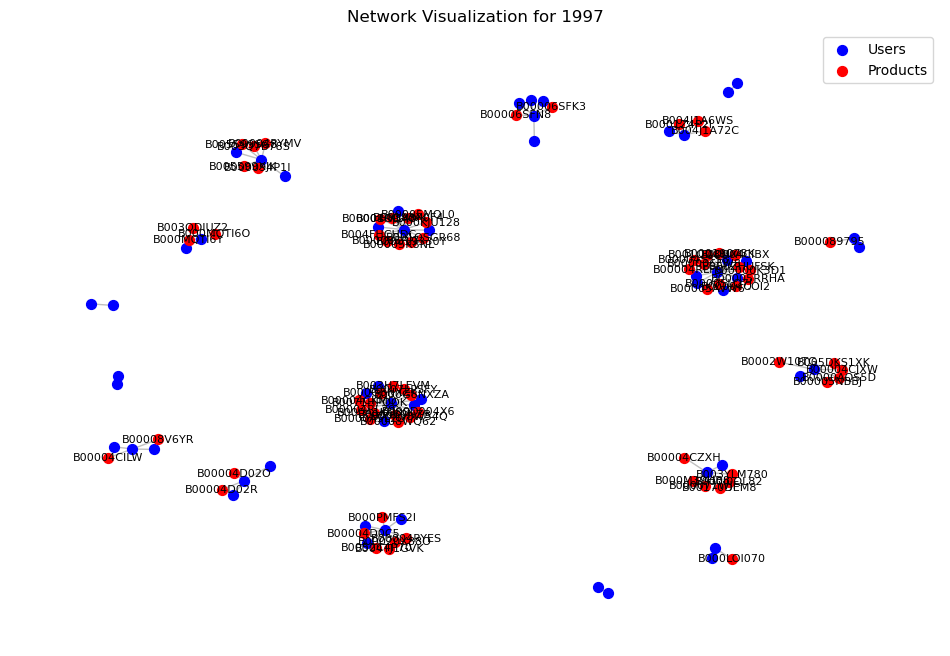

In [7]:
# Step 1: Replace user_ids with integers
user_mapping = {}  # Maps user_id to integer
user_counter = 1  # Start numbering from 1

# Step 2: Create a new graph with updated node labels
G_transformed = nx.Graph()

for u, v, data in G.edges(data=True):
    # Check if the node is a user or product
    if not u.startswith("B"):  # Assume product_id nodes start with "B"
        if u not in user_mapping:
            user_mapping[u] = user_counter
            user_counter += 1
        u_transformed = user_mapping[u]
    else:
        u_transformed = u

    if not v.startswith("B"):
        if v not in user_mapping:
            user_mapping[v] = user_counter
            user_counter += 1
        v_transformed = user_mapping[v]
    else:
        v_transformed = v

    # Add the edge with transformed node labels
    G_transformed.add_edge(u_transformed, v_transformed, **data)

# Step 3: Filter edges for the target year
year_edges = [(u, v, d) for u, v, d in G_transformed.edges(data=True) if d.get("month").startswith(target_year)]
G_year = nx.Graph()
G_year.add_edges_from(year_edges)

# Step 4: Separate nodes by type for coloring
user_nodes = [n for n in G_year.nodes if isinstance(n, int)]  # User nodes are integers
product_nodes = [n for n in G_year.nodes if not isinstance(n, int)]  # Product nodes are strings

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_year)

# Draw user nodes (blue)
nx.draw_networkx_nodes(G_year, pos, nodelist=user_nodes, node_size=50, node_color="blue", label="Users")
# Draw product nodes (red)
nx.draw_networkx_nodes(G_year, pos, nodelist=product_nodes, node_size=50, node_color="red", label="Products")

# Draw edges
nx.draw_networkx_edges(G_year, pos, alpha=0.5, edge_color="gray")

# Add optional labels for product nodes
nx.draw_networkx_labels(G_year, pos, labels={n: n for n in product_nodes}, font_size=8, font_color="black")

# Add title and legend
plt.title(f"Network Visualization for {target_year}")
plt.legend()
plt.axis("off")
plt.show()